In [ ]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics

import keras_cv

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#dir_path = "/content/drive/MyDrive/Cases/Original Image Datasets/Animal"
dir_path = "/content/drive/MyDrive/images-waste-small2.0"

In [ ]:
# BATCH_SIZE = 4
# IMAGE_SIZE = (224, 224)
# AUTOTUNE = tf.data.AUTOTUNE
# tfds.disable_progress_bar()
# train_generator = tf.keras.utils.image_dataset_from_directory(
#     directory=dir_path,  color_mode='rgb',label_mode='int',
#     image_size=IMAGE_SIZE,batch_size=BATCH_SIZE, shuffle=True,subset='training',validation_split=0.2,
#     seed=25)
# validation_generator = tf.keras.utils.image_dataset_from_directory(
#     directory=dir_path, color_mode='rgb',
#     label_mode='int',image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,shuffle=False,subset='validation',validation_split=0.2,
#     seed=25)

import tensorflow as tf
import tensorflow_datasets as tfds

BATCH_SIZE = 4
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

tfds.disable_progress_bar()

train_generator = tf.keras.utils.image_dataset_from_directory(
    directory=dir_path,
    color_mode='grayscale',  # Convert images to grayscale
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training',
    validation_split=0.2,
    seed=25
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    directory=dir_path,
    color_mode='grayscale',  # Convert images to grayscale
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation',
    validation_split=0.2,
    seed=25
)


Found 248 files belonging to 7 classes.
Using 199 files for training.
Found 248 files belonging to 7 classes.
Using 49 files for validation.


In [ ]:
# Create a mapping of class indices to class names
class_map = {i: class_name for i, class_name in enumerate(train_generator.class_names)}

# Print the class map
print(class_map)

{0: 'bottle-cans', 1: 'disposable_plastic_cutlery', 2: 'eggshells', 3: 'food_waste', 4: 'glass-bottles', 5: 'paper', 6: 'plastic-bottles'}


In [ ]:
len(class_names)

7

In [ ]:
train_ds_shuff = train_generator.shuffle(
    3*BATCH_SIZE, reshuffle_each_iteration=True
)
images = next(iter(train_ds_shuff.take(1)))[0]
images.shape

TensorShape([4, 224, 224, 1])

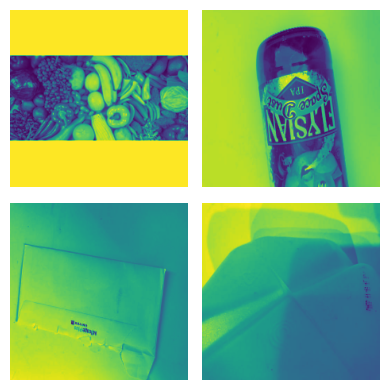

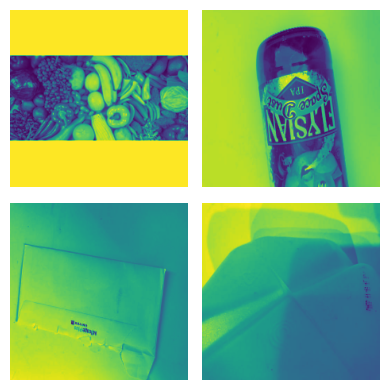

In [ ]:
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [ ]:
keras.backend.clear_session()

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_generator.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = validation_generator.map(lambda x, y: (normalization_layer(x), y))
num_classes = len(train_generator.class_names)  # Get the number of classes

def to_one_hot(image, label):
    label = tf.one_hot(label, num_classes)  # Convert labels to one-hot encoding
    return image, label

normalized_train_ds = normalized_train_ds.map(to_one_hot, num_parallel_calls=AUTOTUNE)
normalized_test_ds = normalized_test_ds.map(to_one_hot, num_parallel_calls=AUTOTUNE)


In [ ]:
# model = keras_cv.models.ImageClassifier.from_preset(
#     "efficientnetv2_b0_imagenet", num_classes=len(class_names)
# )

model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 1),  # Change input channels to 1
    include_top=False,
    weights=None  # Train from scratch since no pre-trained weights exist for 1-channel
)


In [ ]:
# Load pre-trained ResNet model
# model = keras_cv.models.ImageClassifier.from_preset(
#     "resnet50_imagenet", num_classes=len(class_names)
# )

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15,
                        verbose=2, restore_best_weights=True)
model.compile(optimizer=AdamW(learning_rate=0.001),loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

In [ ]:
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            288 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 56, 56, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 56, 56, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 56, 56, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 56, 56, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 56, 56, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2b_expand_conv       │ (None, 56, 56, 128)    │         36,864 │ block2a_project_bn[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,918,736 (22.58 MB)

 Trainable params: 5,858,128 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
r = model.fit(normalized_train_ds,
              validation_data=normalized_test_ds, callbacks=[monitor],
              epochs=15) #time taken: approximately 60m

ValueError: Incompatible shapes for broadcasting: shapes=[(4, 7), (4, 7, 7)]

In [ ]:
model.save('cnn_good_classfier11.keras')

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
from PIL import Image
import numpy as np

# Load the image
path = "/content/Image_113.png"
image = Image.open(path)

# Convert the image to a numpy array
image = np.array(image)

# Normalize the image
image = image / 255.0

# Add a batch dimension
image = np.expand_dims(image, axis=0)

In [ ]:
resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

In [ ]:
np_im_rs = resizing(image)
np_im_rs.shape

Let's look at how our model performs after the fine tuning:

In [ ]:
predictions = model.predict(np_im_rs)
predictions

In [ ]:
print("Top class is:", class_names[np.argmax(predictions[0])])

In [ ]:
# import pickle

# # Save the model to a pickle file
# with open('model_transferL_resNet.pkl', 'wb') as file:
#     pickle.dump(model, file)

# print("Model saved successfully!")


In [ ]:
import pickle

# Save the model to a pickle file
with open('model_transferL_effNet.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully!")